In [4]:
import pandas as pd

# Define the filenames and variable names
dataset_names = [
    "X_train", "X_train_reduced_2", "X_train_reduced_4",
    "X_validate", "X_validate_reduced_2", "X_validate_reduced_4",
    "X_test", "X_test_reduced_2", "X_test_reduced_4",
    "y_train", "y_validate", "train_df", "test_df"
]

# Load each dataset from CSV
datasets = {name: pd.read_csv(f"{name}.csv") for name in dataset_names}

# Unpack variables for direct usage
X_train = datasets["X_train"]
X_train_reduced_2 = datasets["X_train_reduced_2"]
X_train_reduced_4 = datasets["X_train_reduced_4"]
X_validate = datasets["X_validate"]
X_validate_reduced_2 = datasets["X_validate_reduced_2"]
X_validate_reduced_4 = datasets["X_validate_reduced_4"]
X_test = datasets["X_test"]
X_test_reduced_2 = datasets["X_test_reduced_2"]
X_test_reduced_4 = datasets["X_test_reduced_4"]
y_train = datasets["y_train"]
y_validate = datasets["y_validate"]
train_df = datasets["train_df"]
test_df = datasets["test_df"]

print("All datasets loaded successfully! 🎉")


All datasets loaded successfully! 🎉


In [7]:
X_train_reduced_2

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Type,Outlet_Age,Item_Category,Outlet_Identifier_Encoded
0,9.500,1,0.035206,171.3448,2316.181148,10,1,2348.354635
1,18.000,0,0.047473,170.5422,2316.181148,7,2,2192.384798
2,17.600,1,0.076122,111.7202,2316.181148,12,1,2277.844267
3,8.325,0,0.029845,41.6138,2316.181148,7,1,2192.384798
4,12.850,0,0.137228,155.5630,2316.181148,12,1,2277.844267
...,...,...,...,...,...,...,...,...
6813,9.395,1,0.197746,139.1838,339.828500,11,1,339.351662
6814,15.600,0,0.117575,75.6670,2316.181148,2,1,2340.675263
6815,17.600,0,0.018944,237.3590,2316.181148,7,2,2192.384798
6816,20.350,0,0.054363,117.9466,2316.181148,2,1,2340.675263


In [27]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Load data
X_train = pd.read_csv("X_train_reduced_2.csv")
X_validate = pd.read_csv("X_validate_reduced_2.csv")

# Standardize the data (PCA works better with scaled data)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

# Apply PCA
pca = PCA(n_components=0.85)  # Keep 90% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_validate_pca = pca.transform(X_validate_scaled)

# Print explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"✅ PCA Retained {explained_variance:.2%} Variance with {X_train_pca.shape[1]} Components")

# Convert back to DataFrame
X_train_pca = pd.DataFrame(X_train_pca)
X_validate_pca = pd.DataFrame(X_validate_pca)

# Save transformed data
X_train_pca.to_csv("X_train_PCA.csv", index=False)
X_validate_pca.to_csv("X_validate_PCA.csv", index=False)

print("✅ PCA Applied & Saved!")


✅ PCA Retained 89.75% Variance with 6 Components
✅ PCA Applied & Saved!


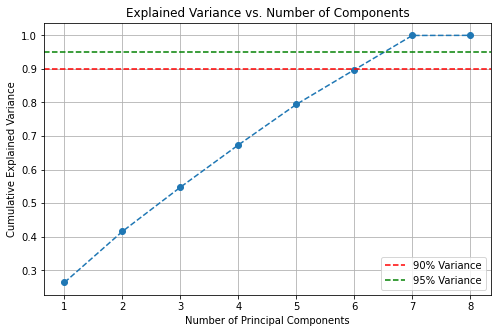

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
X_train = pd.read_csv("X_train_reduced_2.csv")

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA()
pca.fit(X_train_scaled)

# Plot explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.axhline(y=0.95, color='g', linestyle='--', label="95% Variance")
plt.legend()
plt.grid()
plt.show()


In [29]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define best parameters
best_params = {
    'learning_rate': 0.05,
    'num_leaves': 30,
    'max_depth': 9,
    'min_child_samples': 20,
    'colsample_bytree': 0.95,
    'subsample': 0.9,
    'reg_lambda': 10,
    'reg_alpha': 10,
    'n_estimators': 1000,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt'
}

# Create dataset for LightGBM
train_data = lgb.Dataset(X_train_pca, label=y_train)
validate_data = lgb.Dataset(X_validate_pca, label=y_validate, reference=train_data)

# Train LightGBM with early stopping as a callback
model = lgb.train(
    best_params,
    train_data,
    valid_sets=[validate_data],  # Validation set for early stopping
    callbacks=[early_stopping(50), log_evaluation(100)]
)

# Predictions
y_pred_train = model.predict(X_train_pca)
y_pred_validate = model.predict(X_validate_pca)

# Model evaluation function
def evaluate_model(y_true, y_pred, dataset_name="Validation"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"✅ Model Performance on {dataset_name} Set:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")

# Evaluate
evaluate_model(y_train, y_pred_train, "Training")
evaluate_model(y_validate, y_pred_validate, "Validation")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 6
[LightGBM] [Info] Start training from score 2202.365232
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1040.98
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[84]	valid_0's rmse: 1040.22
✅ Model Performance on Training Set:
MAE: 705.5005
MSE: 978012.3870
RMSE: 988.9451
R² Score: 0.6694

✅ Model Performance on Validation Set:
MAE: 728.9960
MSE: 1082050.8961
RMSE: 1040.2168
R² Score: 0.6019



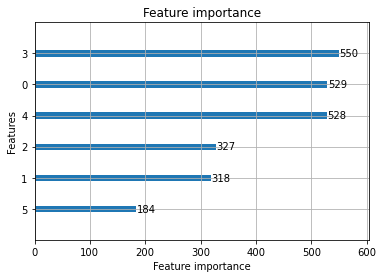

In [30]:
lgb.plot_importance(model, max_num_features=20)  
plt.show()


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importance = model.feature_importance()
feature_names = X_train_pca.columns  # Ensure these are the correct feature names

# Create DataFrame
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# ✅ Convert all feature names to strings before filtering
outlet_features = [str(col) for col in feat_imp_df["Feature"] if "outlet" in str(col).lower()]
outlet_feat_imp = feat_imp_df[feat_imp_df["Feature"].isin(outlet_features)]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=outlet_feat_imp)
plt.title("Outlet-Related Feature Importance")
plt.show()


ValueError: min() arg is an empty sequence

<Figure size 576x360 with 0 Axes>